# Libraries:

In [289]:
# Importing, Engineering, and Transforming data:
import pandas as pd

# Plotting and transforming dates to int:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

# Importing and Formating Data:

Lets import the whole dataframe first:

In [290]:
#Importing dataframe:
df = pd.read_csv('data/btc_full.csv')
df

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
0,2009-01-03,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-04,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-05,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-06,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-07,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4670,2021-10-17,823877,9510,2255731,15888054,1059,473945,6811649,42,99633,...,647306,160870.915843,9.887484e+09,0.616356,37882.607707,0.001942,119.337509,13.809296,0.042169,0.041225
4671,2021-10-18,1003479,9502,2250888,15884957,1062,473463,6806663,42,99626,...,831346,330556.772199,2.048694e+10,0.788223,48851.737200,0.002725,168.885623,13.828260,0.042039,0.041163
4672,2021-10-19,1077371,9505,2250116,15878533,1063,473462,6805237,42,99610,...,875427,326167.703405,2.096961e+10,0.779997,50146.733450,0.002670,171.656697,13.829810,0.042009,0.041098
4673,2021-10-20,977215,9505,2250513,15901628,1062,473548,6808855,43,99638,...,838275,317350.333699,2.096473e+10,0.878893,58061.271589,0.002809,185.542483,13.837917,0.042028,0.035842


Now let's create a function to look for the row number when each feature starts having continuosly valid data. We will use it later to drop the early datapoints that contains null values: 

In [291]:
# Finding the oldest nulls in the dataframe:
def max_null_df(df):
    '''Returns a dataframe with all the columns and the row number
    of the most recent datapoint that contains a null value.    
    Input: dataframe
    Output: dataframe '''

    max_null_df = pd.DataFrame(columns=['column', 'oldest_null'])
    i = 0
    for column in df.columns:
        max_null_df.loc[i] = [column, df[df[column].isnull() == True].index.max()]
        i += 1

    return max_null_df

max_null_df(df).sort_values(by='oldest_null', ascending=False)

,column,oldest_null
69,ROI1yr,925
138,VtyDayRet180d,740
66,NVTAdjFF90,650
64,NVTAdj90,649
139,VtyDayRet30d,590
...,...,...
126,SplyMiner1HopAllNtv,NaN
128,TxCnt,NaN
129,TxCntSec,NaN
130,TxTfrCnt,NaN


To complement the null value analysis, lets create a function that shows us the proportion of the data that contains null values:

In [292]:
def null_percentages(df):
    '''Returns a table with the number and percentage of datapoints that
    are null for each column/feature
    Input: dataframe
    Output: dataframe'''

    null_num = df.isnull().sum().sort_values(ascending=False)
    null_perc = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False) * 100
    null_tot = pd.concat([null_num, null_perc], axis=1, keys=['Null #', 'Null %'])
    
    return null_tot[null_tot['Null #'] != 0]

null_percentages(df)

,Null #,Null %
ROI1yr,926,19.807487
VtyDayRet180d,741,15.850267
NVTAdjFF90,651,13.925134
NVTAdj90,650,13.903743
ROI30d,591,12.641711
...,...,...
FeeByteMeanNtv,6,0.128342
DiffMean,6,0.128342
DiffLast,6,0.128342
NDF,6,0.128342


Now lets streamline the dataframe a little and keep just what we are going to use:

In [293]:
# Formatting date and indexing by date:
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True, drop=False)

# convert date to number to use as input for the models:
df['date'] = df['date'].map(mdates.date2num)

# Narrowing down Features: DO BEFORE DROPPING NULL


# dropping obs with null values:


# df = df.iloc[max_null_row(df):]



#filtering dates:
# df.loc['2015-07-03' : '2015-07-10']
# df.loc['2015-07-03']
df

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
date,,,,,,,,,,,,,,,,,,,,,
2009-01-03,14247.0,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-04,14248.0,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-05,14249.0,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-06,14250.0,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-07,14251.0,0,0,0,0,0,0,0,0,0,...,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-17,18917.0,823877,9510,2255731,15888054,1059,473945,6811649,42,99633,...,647306,160870.915843,9.887484e+09,0.616356,37882.607707,0.001942,119.337509,13.809296,0.042169,0.041225
2021-10-18,18918.0,1003479,9502,2250888,15884957,1062,473463,6806663,42,99626,...,831346,330556.772199,2.048694e+10,0.788223,48851.737200,0.002725,168.885623,13.828260,0.042039,0.041163
2021-10-19,18919.0,1077371,9505,2250116,15878533,1063,473462,6805237,42,99610,...,875427,326167.703405,2.096961e+10,0.779997,50146.733450,0.002670,171.656697,13.829810,0.042009,0.041098


# Data Visualization:

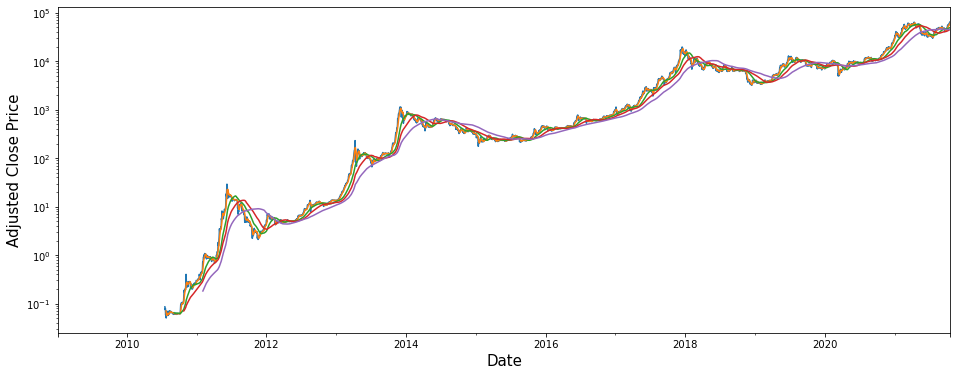

In [294]:
# Visualize the training stock data:
price_usd = df.PriceUSD
dma_7 = price_usd.rolling(window=7).mean()
dma_50 = price_usd.rolling(window=50).mean()
dma_100 = price_usd.rolling(window=100).mean()
dma_200 = price_usd.rolling(window=200).mean()


plt.figure(figsize = (16,6))
price_usd.plot(label='PriceUSD')
dma_7.plot(label='7 DMA')
dma_50.plot(label='50 DMA')
dma_100.plot(label='100 DMA')
dma_200.plot(label='200 DMA')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.yscale('log')

plt.show()